# Calibration

This notebook demonstrates how we can calibrate the network of sensors using the colocation events.

In [5]:
import pandas as pd
from google.cloud import bigquery
import numpy as np
import pickle
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
import download_airnow_web
import pyproj
%matplotlib inline
from glob import glob
import google.auth
from google.cloud import bigquery_storage
from pathlib import Path
import os


### Methods

Helper methods for accessing and processing data

In [6]:
pathtofolders = 'data'

In [7]:
def processBAMdata():
    '''reading bam data
    '''
    metadf = pd.read_excel(pathtofolders+'/BAM Metadata.xlsx')
    print("Device Ids: ")
    print(metadf['Id'].unique())
    
    nakawabam = pd.read_csv(pathtofolders+'/nakawabam.csv')#Nakawa BAM
    nakawabam["channel_id"] = -24517
    nakawabam["latitude"] = metadf['Latitude'].iloc[0]
    nakawabam["longitude"] = metadf['Longitude'].iloc[0]
    #print(nakawabam)
    
    mukbam = pd.read_csv(pathtofolders+'/mukbam.csv')#MUK BAM
    mukbam["channel_id"] = -24516
    mukbam["latitude"] = metadf['Latitude'].iloc[1]
    mukbam["longitude"] = metadf['Longitude'].iloc[1]
    #print(mukbam)
       
    allbamdf = pd.concat([nakawabam, mukbam], ignore_index=True)
    allbamdf.rename(columns={'Time':'created_at','ConcHR(ug/m3)':'pm2_5'},inplace=True)
   
    
    return allbamdf

In [8]:
def loaddata(bigquery_account_json,nextdays=5):
    """
    Load data from main GCP database.
    Pass it the path to your CGP key.
    Returns a dataframe of all the sensor data.
    
    Currently this version just downloads the next five days of data from the oldest data in the cache.
    If you want to download more, change 'nextdays' parameter to a larger number. If you set it to, for
    example 30000 it will download all the data.
    """
    #client = bigquery.Client.from_service_account_json(bigquery_account_json)
    client = bigquery.Client.from_service_account_json("airqo-250220-5149c2aac8f2.json")
    
    try:
        df = pickle.load(open('alldata.p','rb'))
        mostrecent = df['created_at'].max()
        nexttimestep = mostrecent + pd.Timedelta(nextdays,'day')
        mostrecent = mostrecent.strftime('%Y-%m-%d')
        
        
        nexttimestep = nexttimestep.strftime('%Y-%m-%d')
        print("Found cache file containing data up to %s" % mostrecent)
        print("Downloading more data to date %s" % nexttimestep)
        sql = """SELECT * FROM `airqo-250220.thingspeak.clean_feeds_pms` WHERE (created_at >= DATETIME('%s')) AND (created_at < DATETIME('%s'))""" % (mostrecent,nexttimestep)
        print("SQL query:")
        print(sql)
        d = client.query(sql)
        print("Query complete, converting to dataframe...")
        d = d.to_dataframe()     
        print("done")
        print(d)
        print("Concatenating with cached data...")
        df = pd.concat([df,d]) #ugh, memory issues: https://www.confessionsofadataguy.com/solving-the-memory-hungry-pandas-concat-problem/
        print("Dropping duplicates...")
        df = df.drop_duplicates() #we are likely to have duplicates as the create_at threshold is a bit vague
    except FileNotFoundError:
        print("cache file ('alldata.p') not found. Downloading entire dataset, this may take some time.")
        sql = """SELECT * FROM `airqo-250220.thingspeak.clean_feeds_pms`"""
        dfx = client.query(sql)
        #.to_dataframe()
        df = dfx.to_dataframe()
    print("Saving new cache")
    pickle.dump(df,open('alldata.p','wb'))
    return df

In [9]:
def combinedatasets(df,otherdf, distfromboxcentre = 40e3, boxlat=0.313611, boxlong=32.581111):
    """
    Merge 'otherdf' into 'df'.
    Only include data from either that is within distfromboxcentre (in metres) from boxlat and boxlong.
    Adds x and y columns for Northings and Eastings.
    """

    df = pd.concat([df, otherdf[['created_at','channel_id','pm2_5','latitude','longitude']]])
    #Convert to northings and eastings
    epsg3857 = pyproj.Proj(init='epsg:3857') #EPSG:3857 -- WGS84 Web Mercator [used by websites]
    wgs84 = pyproj.Proj(init='EPSG:4326') #WGS 84 [used by GPS satellite system]
    boxcentre = pyproj.transform(wgs84,epsg3857,boxlong,boxlat)
    longs = df['longitude'].tolist()
    lats = df['latitude'].tolist()

    df['x'],df['y'] = pyproj.transform(wgs84,epsg3857,longs,lats)

    #Only keep items that are in a box around Kampala
    df = df[(df['x']>boxcentre[0]-distfromboxcentre)]
    df = df[(df['x']<boxcentre[0]+distfromboxcentre)]
    df = df[(df['y']>boxcentre[1]-distfromboxcentre)]
    df = df[(df['y']<boxcentre[1]+distfromboxcentre)]
    return df


In [10]:
def build_encounters(df,prox = 20,timeprox = 30):
    """
    Build a new dataframe containing the pairs of measurements that happen near each other.
    
    Input dataframe needs these columns:
        channel_id
        created_at
        latitude (lat/long only included to check they are 'sensible' and not NAN)
        longitude
        pm2_5
        x (Easting and Northing in m)
        y        
    prox = proximity in metres
    timeprox = proximity in minutes
    
    Returns a dataframe containing two copies of all the columns of the original (one for each sensor)
    with additionally a column for timedelta and dist (in m) between the two observations.
    """
    dfs = []
    encounters = None
    for cid in df['channel_id'].unique():
        df['created_at_2']=df['created_at']
        dfs.append(df[df['channel_id']==cid])
    for i,d1 in enumerate(dfs):
        #for d2 in dfs[i+1:]:
        for j,d2 in enumerate(dfs):
            if i==j:continue
            newdf = pd.merge_asof(d1.sort_values("created_at"),d2.sort_values("created_at"),on='created_at',tolerance=pd.Timedelta(timeprox,'minutes'),direction='nearest',suffixes=('_sensorA', '_sensorB')). \
                dropna(subset=["created_at","created_at_2_sensorA",'latitude_sensorA','longitude_sensorA', 'latitude_sensorB', 'longitude_sensorB','pm2_5_sensorA','pm2_5_sensorB'])
            #leaving this line in might make it quicker, as I compute a sqrt (somewhat unnecessarily for a lot of data)
            #newdf = newdf[(np.abs(newdf['x_sensorA']-newdf['x_sensorB'])<prox) & (np.abs(newdf['y_sensorA']-newdf['y_sensorB'])<prox)]
            newdf['dist'] = np.sqrt((newdf['x_sensorA']-newdf['x_sensorB'])**2 + (newdf['y_sensorA']-newdf['y_sensorB'])**2)
            newdf = newdf[newdf['dist']<prox]
            newdf['timedelta'] = np.abs(newdf['created_at_2_sensorA']-newdf['created_at_2_sensorB'])
            encounters = pd.concat([encounters,newdf])
        print("%d of %d (%d encounters recorded)" % (i+1,len(dfs),len(encounters)))
    return encounters


In [11]:
def plotsensorencounters(df,box=100):
    """
    For each sensor find its median location and plot all the sensors around it over all time.
    This just was useful to confirm that sensor visits were as intended.
    """
    i=0
    unq = df['channel_id'].unique()
    len(unq)
    plt.figure(figsize=[8*4,8*4])
    for cid in unq:
        i+=1
        boxc=[0,0]
        boxc[0] = np.median(df[df['channel_id']==cid]['x'])
        boxc[1] = np.median(df[df['channel_id']==cid]['y'])
        plt.subplot(8,8,i)
        if cid in [930428,930430]: continue

        for channel_id in unq:
            #print(channel_id)
            chandf = df[df['channel_id']==channel_id]
            chandf = chandf[(chandf['x']>boxc[0]-box) & (chandf['x']<boxc[0]+box) & (chandf['y']>boxc[1]-box) & (chandf['y']<boxc[1]+box)]
            if channel_id in [-1,930428,930430]:
                dotsize = 3
            else:
                dotsize = 3
            if len(chandf)>0:
                plt.scatter(chandf['x'],chandf['y'],dotsize,label="%d (%d)" % (channel_id,len(chandf)))
        plt.legend()
        plt.xlim([boxc[0]-box,boxc[0]+box])
        plt.ylim([boxc[1]-box,boxc[1]+box])
        plt.title(cid)
        #plt.plot(embassyxy['x'],embassyxy['y'],'x',markersize=20)
        plt.grid()

In [12]:
import pickle
airqodf = loaddata("airqo-250220-5149c2aac8f2.json")
pickle.dump(airqodf,open('airqodf.p','wb'))
airqodf = pickle.load(open('airqodf.p','rb'))

Found cache file containing data up to 2020-11-21
SQL query:
SELECT * FROM `airqo-250220.thingspeak.clean_feeds_pms` WHERE (created_at >= DATETIME('2020-11-21')) AND (created_at < DATETIME('2020-11-26'))
Query complete, converting to dataframe...
done
              created_at  channel_id  entry_id   pm2_5    pm10  s2_pm2_5  \
0    2020-11-21 00:14:09      912225    258690  115.30  124.23    151.95   
1    2020-11-21 00:01:47      782718    338928  107.22  111.70     14.85   
2    2020-11-21 00:26:32      782718    338946  110.47  112.57      7.17   
3    2020-11-21 00:18:28      782718    338940  117.08  120.48     11.55   
4    2020-11-21 02:07:26      782718    339016  134.38  138.20     12.12   
...                  ...         ...       ...     ...     ...       ...   
9017 2020-11-21 05:06:28      730014    529323  117.85  120.83    128.27   
9018 2020-11-21 02:27:19      730014    529207   65.75   72.22     72.83   
9019 2020-11-21 01:07:23      730014    529149   46.05   55.67  

In [13]:
airqodf.head(10)

,created_at,channel_id,entry_id,pm2_5,pm10,s2_pm2_5,s2_pm10,latitude,longitude,voltage,altitude,wind,no_sats,hdope,temperature,humidity
0,2020-04-27 09:59:30,832251,240365,15.38,15.97,16.82,17.02,0.299244,32.592663,4.30,1202.7,0.00,9.0,84.0,0.0,0.0
1,2020-04-27 11:57:59,832251,240452,12.93,14.22,14.55,14.90,0.299249,32.592686,4.30,1203.1,0.03,9.0,98.0,0.0,0.0
2,2020-04-27 11:36:24,832251,240438,10.22,10.32,7.15,7.32,0.299251,32.592667,4.30,1207.2,0.02,9.0,97.0,0.0,0.0
3,2020-04-27 23:48:44,832251,240950,27.90,29.52,27.93,30.05,0.299261,32.592655,4.30,1203.5,0.01,9.0,94.0,0.0,0.0
4,2020-04-27 22:10:45,832251,240886,27.58,28.55,28.73,32.22,0.299270,32.592667,4.30,1212.9,0.01,9.0,90.0,0.0,0.0
5,2020-04-27 23:45:55,832251,240948,28.17,29.22,25.45,30.55,0.299277,32.592667,4.30,1202.3,0.01,9.0,89.0,0.0,0.0
6,2020-04-27 12:59:11,832251,240493,7.45,7.88,6.55,6.93,0.299221,32.592682,4.30,1200.9,0.02,9.0,119.0,0.0,0.0
7,2020-04-27 14:35:19,832251,240562,20.88,22.90,21.42,24.85,0.299221,32.592682,4.30,1204.9,0.00,9.0,118.0,0.0,0.0
8,2020-04-27 10:03:33,832251,240368,11.88,12.78,11.78,12.30,0.299274,32.592670,4.30,1210.5,0.01,9.0,106.0,0.0,0.0
9,2020-04-28 03:08:22,832251,241094,25.77,28.57,24.17,31.75,0.299241,32.592720,4.31,1214.2,0.07,9.0,85.0,0.0,0.0


Download latest embassy data, add its latitude, longitude, channel_id (-1) and add new columns renaming them to our conventions.

In [14]:
airqodf.shape

(23767381, 16)

In [15]:
embassydf = download_airnow_web.download('Kampala')
embassydf['pm2_5'] = embassydf['Raw Conc.']
embassydf['created_at'] = embassydf['Date (LT)']
embassydf['channel_id']=-1
embassydf['latitude'] = 0.299333
embassydf['longitude'] = 32.592539

The BAM data has been copied from the google folder Joel set up. This method parses that data and converts to a dataframe.

In [16]:
# bamdf =  processBAMdata(r'data/BAM',{'Y24517':-24517,'Y24516':-24516})


In [17]:
bamdf = processBAMdata()
bamdf

Device Ids: 
['Y24517' 'Y24516']


,created_at,ConcRT(ug/m3),pm2_5,ConcS(ug/m3),Flow(lpm),WS(m/s),WD(Deg),AT(C),RH(%),BP(mmHg),FT(C),FRH(%),Status,channel_id,latitude,longitude
0,2020-09-19 16:25:00,99999.0,99999.0,99999.0,16.69,0.6,177,23.5,71,660.3,25.3,51,256,-24517,0.331705,32.609860
1,2020-09-19 16:00:00,31456.9,36.8,42.5,16.66,0.4,190,25.9,63,660.2,27.3,45,384,-24517,0.331705,32.609860
2,2020-09-19 17:00:00,50.0,61.3,71.3,16.59,0.3,151,27.6,58,660.3,30.9,38,0,-24517,0.331705,32.609860
3,2020-09-19 18:00:00,79.5,90.1,103.9,16.59,0.3,165,25.7,65,660.7,30.1,41,0,-24517,0.331705,32.609860
4,2020-09-19 19:00:00,65.1,66.9,76.6,16.59,0.3,120,23.6,75,661.2,27.7,49,0,-24517,0.331705,32.609860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4577,2020-10-21 08:30:00,30.2,41.0,46.5,16.53,0.6,219,21.0,90,658.9,30.4,39,0,-24516,0.333505,32.568577
4578,2020-10-21 09:00:00,31.6,36.7,41.8,16.65,0.6,176,21.9,87,659.1,31.7,36,0,-24516,0.333505,32.568577
4579,2020-10-21 09:30:00,54.2,36.7,41.8,16.53,0.6,184,21.9,86,659.4,32.0,36,0,-24516,0.333505,32.568577
4580,2020-10-21 10:00:00,44.8,44.5,50.9,16.65,0.6,162,22.5,85,659.4,32.4,35,0,-24516,0.333505,32.568577


I found that I ran out of memory doing some of this, so I drop many of the columns from the GCP airqo database.

In [18]:
airqodf = airqodf.drop(['entry_id','pm10','voltage','s2_pm10','altitude','wind','no_sats','hdope'],axis=1)

Here we move everything to UTC:
- the AirQo data is already in UTC
- the BAM and Embassy data are in local time, so they get converted.

We then call our 'combinedatasets' method to merge the three sets together, and save them.

In [19]:
airqodf['created_at'] = airqodf['created_at'].dt.tz_localize('UTC')
bamdf['created_at'] = pd.to_datetime(bamdf['created_at'],format="%Y-%m-%d %H:%M:%S").dt.tz_localize('Africa/Kampala').dt.tz_convert('UTC')
embassydf['created_at'] = pd.to_datetime(embassydf['created_at'],format="%Y-%m-%d %I:%M %p").dt.tz_localize('Africa/Kampala').dt.tz_convert('UTC')

df = combinedatasets(airqodf,bamdf)
df = combinedatasets(df,embassydf)
pickle.dump(df,open('alldataprocessed.p','wb'))

C:\Users\User\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\User\Anaconda3\lib\site-packages\pyproj\crs\crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\Users\User\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindf

# Analysis

The above processing and collecting of the data is quite time consuming, so to use a saved version we just can start here.

In [20]:
df = pickle.load(open('alldataprocessed.p','rb'))

No handles with labels found to put in legend.


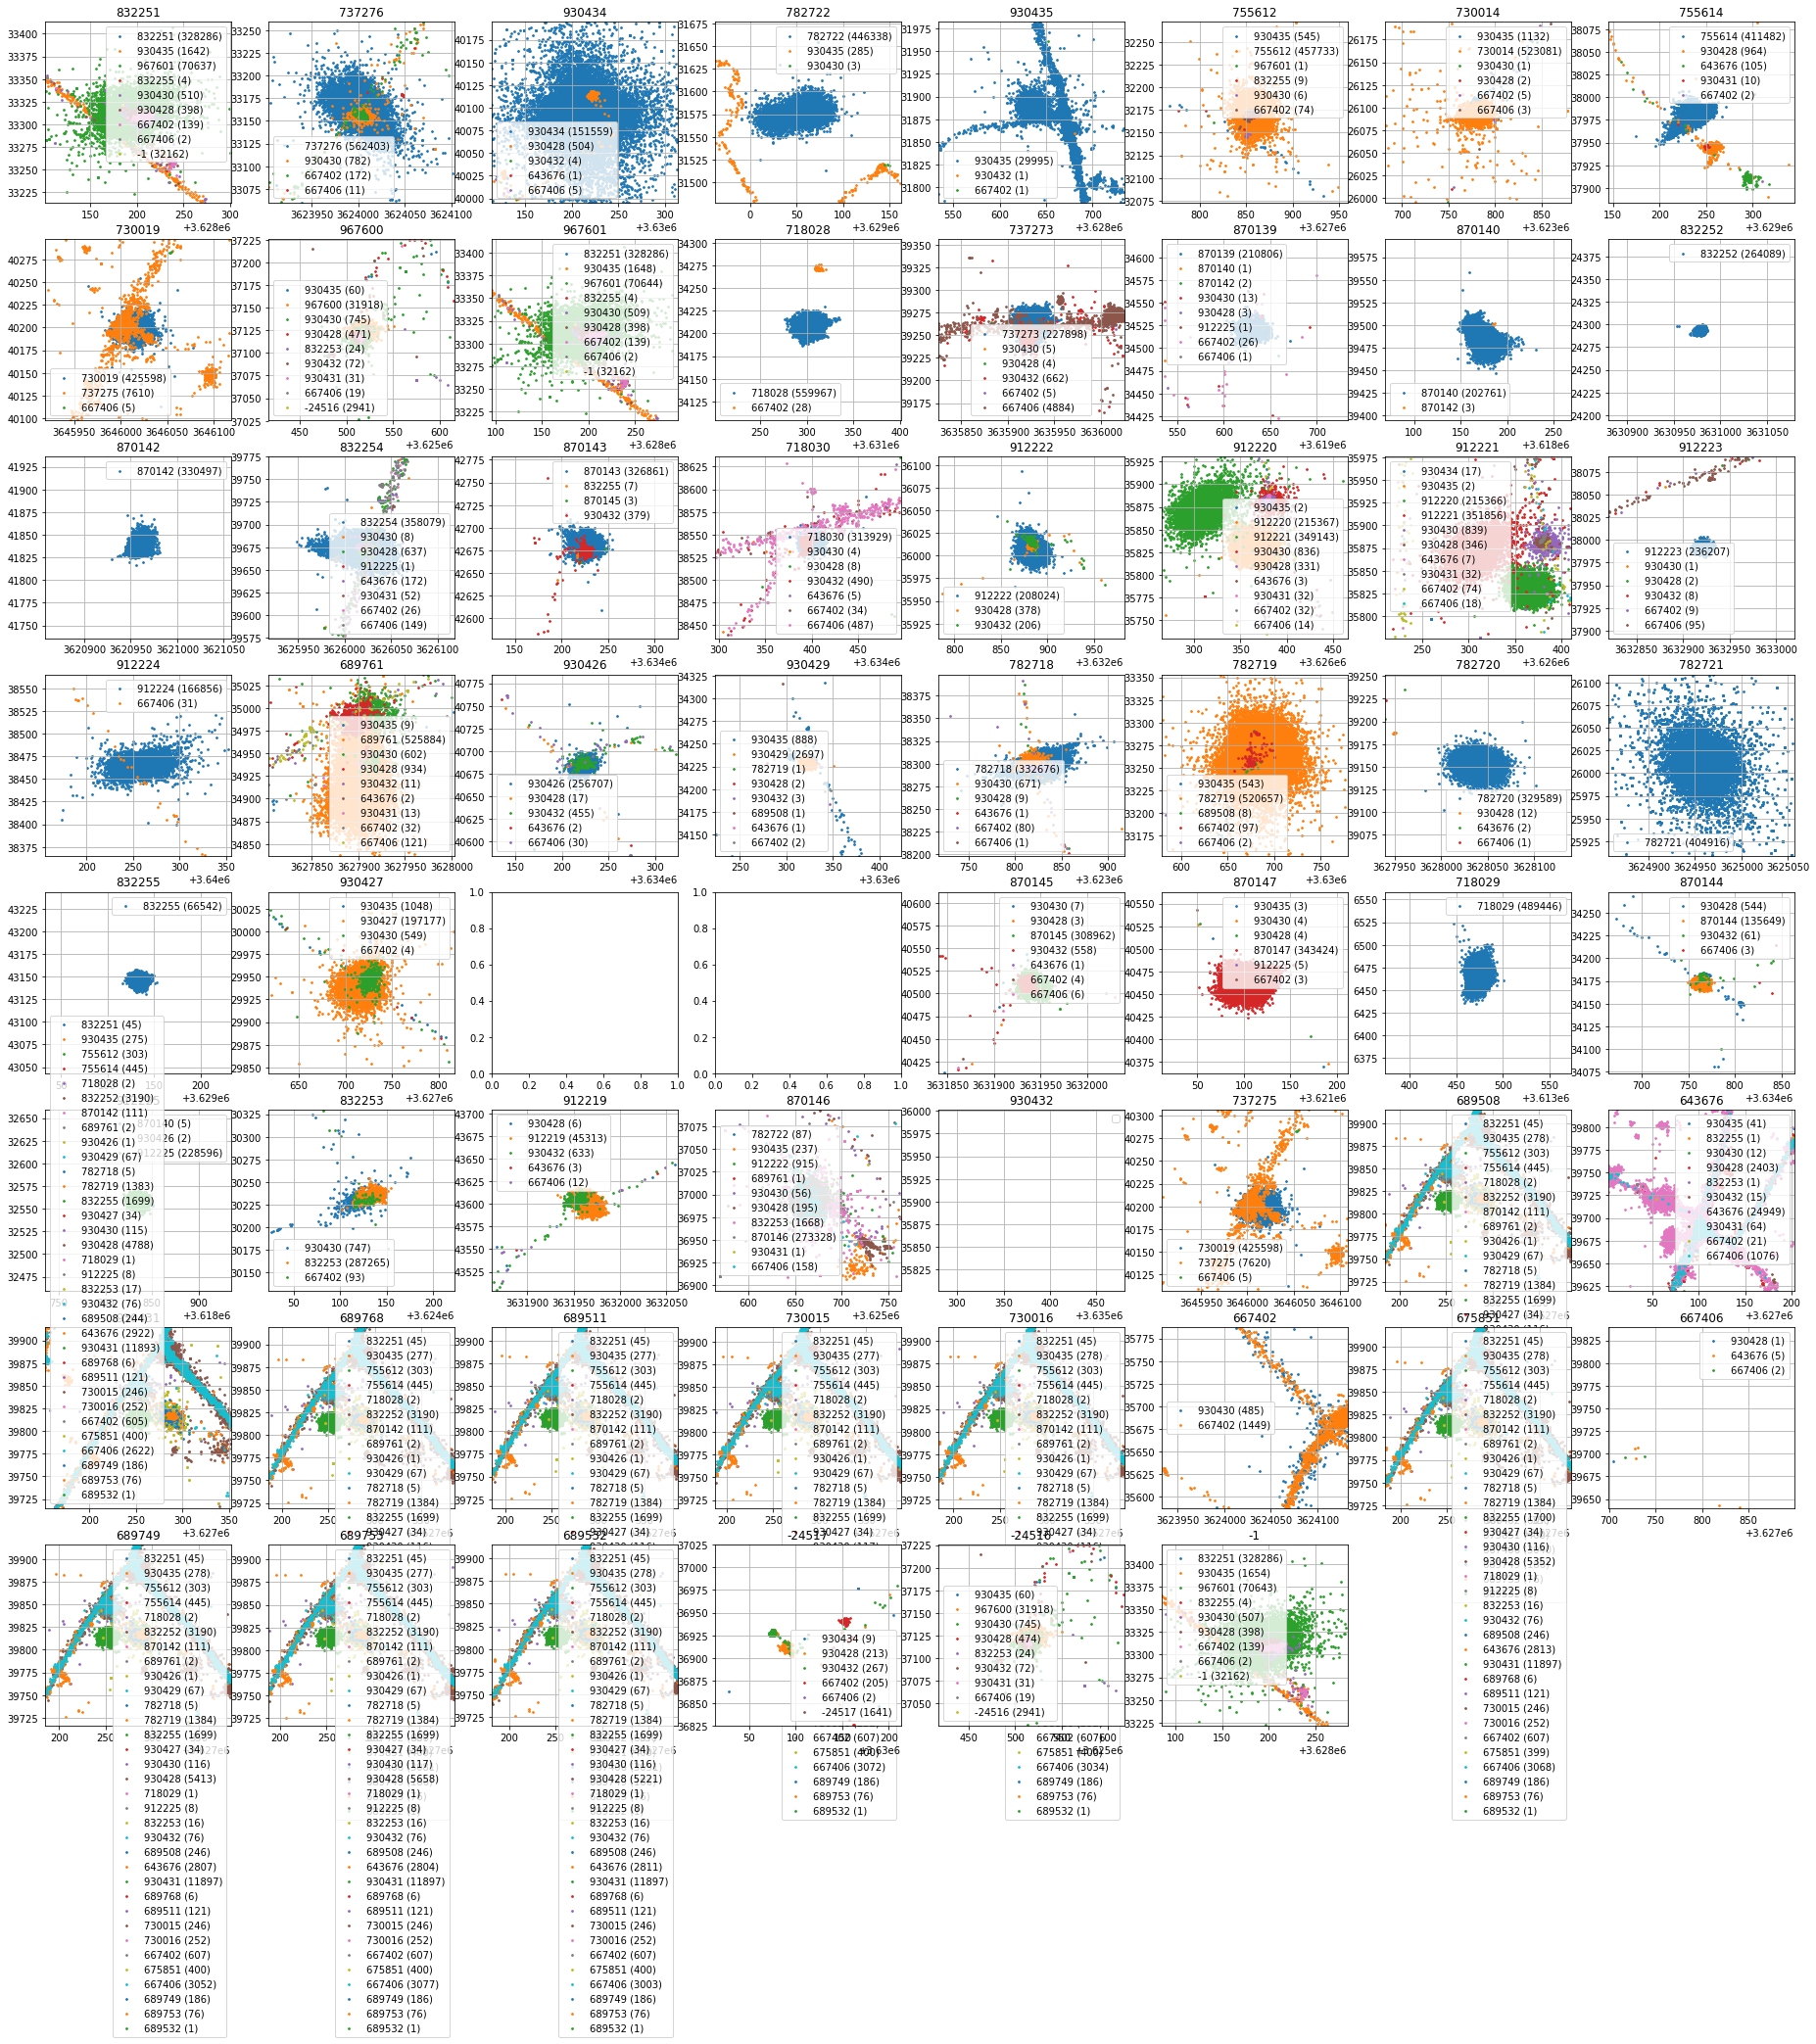

In [21]:
plotsensorencounters(df)

In [22]:
#just use recent data
df = df[df['created_at']>pd.Timestamp('2020-07-15',tz='UTC')]

In [23]:
df

,created_at,channel_id,pm2_5,s2_pm2_5,latitude,longitude,temperature,humidity,x,y
744,2020-08-03 05:16:34+00:00,930434,49.03,45.88,0.360187,32.610764,29.0,0.0,3.630214e+06,40096.097527
745,2020-08-03 05:18:00+00:00,930434,49.30,45.72,0.360252,32.610779,29.0,0.0,3.630215e+06,40103.333437
746,2020-08-02 17:48:19+00:00,930434,50.30,42.43,0.360179,32.610783,31.0,0.0,3.630216e+06,40095.206954
747,2020-08-02 21:06:39+00:00,930434,56.03,50.82,0.360233,32.610500,32.0,0.0,3.630184e+06,40101.218325
748,2020-08-02 21:14:50+00:00,930434,52.32,50.43,0.360192,32.610695,32.0,0.0,3.630206e+06,40096.654136
...,...,...,...,...,...,...,...,...,...,...
229,2020-11-10 11:00:00+00:00,-1,26.00,NaN,0.299333,32.592539,NaN,NaN,3.628185e+06,33321.748717
230,2020-11-10 12:00:00+00:00,-1,-999.00,NaN,0.299333,32.592539,NaN,NaN,3.628185e+06,33321.748717
231,2020-11-10 13:00:00+00:00,-1,-999.00,NaN,0.299333,32.592539,NaN,NaN,3.628185e+06,33321.748717
232,2020-11-10 14:00:00+00:00,-1,-999.00,NaN,0.299333,32.592539,NaN,NaN,3.628185e+06,33321.748717


Here we build the encounters dataframe, this records all the times two sensors are near each other.
It can take a few minutes, so if you've already run it - skip to loading it on the next line.

In [24]:
encounters = build_encounters(df)
pickle.dump(encounters,open('encounters.p','wb'))

1 of 49 (38 encounters recorded)
2 of 49 (38 encounters recorded)
3 of 49 (5278 encounters recorded)
4 of 49 (5495 encounters recorded)
5 of 49 (5890 encounters recorded)
6 of 49 (5892 encounters recorded)
7 of 49 (5892 encounters recorded)
8 of 49 (29668 encounters recorded)
9 of 49 (89552 encounters recorded)
10 of 49 (89552 encounters recorded)
11 of 49 (89736 encounters recorded)
12 of 49 (89737 encounters recorded)
13 of 49 (89932 encounters recorded)
14 of 49 (89932 encounters recorded)
15 of 49 (89932 encounters recorded)
16 of 49 (89932 encounters recorded)
17 of 49 (90196 encounters recorded)
18 of 49 (90355 encounters recorded)
19 of 49 (90365 encounters recorded)
20 of 49 (90524 encounters recorded)
21 of 49 (90705 encounters recorded)
22 of 49 (90870 encounters recorded)
23 of 49 (90872 encounters recorded)
24 of 49 (91356 encounters recorded)
25 of 49 (91505 encounters recorded)
26 of 49 (91505 encounters recorded)
27 of 49 (91505 encounters recorded)
28 of 49 (91508 encou

In [25]:
encounters = pickle.load(open('encounters.p','rb'))

Just makes a list of unique channel ids.

In [26]:
unq = np.unique(np.r_[encounters['channel_id_sensorA'].unique(),encounters['channel_id_sensorB'].unique()])

In [27]:
unq

array([-2.45170e+04, -2.45160e+04, -1.00000e+00,  6.89761e+05,
        7.18030e+05,  7.30014e+05,  7.37273e+05,  7.37276e+05,
        7.55612e+05,  7.55614e+05,  7.82718e+05,  7.82719e+05,
        8.32251e+05,  8.32253e+05,  8.32254e+05,  8.32255e+05,
        8.70139e+05,  8.70143e+05,  8.70144e+05,  8.70145e+05,
        8.70147e+05,  9.12219e+05,  9.12220e+05,  9.12222e+05,
        9.30426e+05,  9.30427e+05,  9.30428e+05,  9.30429e+05,
        9.30430e+05,  9.30431e+05,  9.30432e+05,  9.30434e+05,
        9.30435e+05,  9.67600e+05,  9.67601e+05])

Plots all the channel pairs, to let us see where our encounter data lies, and how it looks

This is a plot with x-axis=time and y-axis is each sensor.
Each vertical line is a colocation event.

In [28]:
df = pickle.load(open('alldataprocessed.p','rb'))
encounters = pickle.load(open('encounters.p','rb'))
unq = df['channel_id'].unique()

In [29]:
encounters

,created_at,channel_id_sensorA,pm2_5_sensorA,s2_pm2_5_sensorA,latitude_sensorA,longitude_sensorA,temperature_sensorA,humidity_sensorA,x_sensorA,y_sensorA,...,s2_pm2_5_sensorB,latitude_sensorB,longitude_sensorB,temperature_sensorB,humidity_sensorB,x_sensorB,y_sensorB,created_at_2_sensorB,dist,timedelta
20171,2020-08-06 12:51:18+00:00,930434,47.15,43.37,0.360178,32.610779,37.0,0.0,3.630215e+06,40095.095632,...,44.33,0.360328,32.610836,39.0,0.0,3.630222e+06,40111.793886,2020-08-06 12:51:20+00:00,17.863185,0 days 00:00:02
20174,2020-08-06 12:55:33+00:00,930434,48.13,43.22,0.360345,32.610737,37.0,0.0,3.630211e+06,40113.686354,...,44.67,0.360342,32.610817,39.0,0.0,3.630220e+06,40113.352389,2020-08-06 12:55:38+00:00,8.911819,0 days 00:00:05
20178,2020-08-06 13:01:08+00:00,930434,48.13,44.78,0.360157,32.610783,37.0,0.0,3.630216e+06,40092.757876,...,44.33,0.360325,32.610817,38.0,0.0,3.630220e+06,40111.459921,2020-08-06 13:00:56+00:00,19.081185,0 days 00:00:12
20181,2020-08-06 13:05:23+00:00,930434,48.05,44.63,0.360186,32.610783,37.0,0.0,3.630216e+06,40095.986205,...,44.67,0.360348,32.610825,38.0,0.0,3.630220e+06,40114.020319,2020-08-06 13:05:14+00:00,18.630320,0 days 00:00:09
25578,2020-08-12 08:52:28+00:00,930434,39.97,37.83,0.360162,32.610806,36.0,0.0,3.630218e+06,40093.314485,...,37.00,0.360334,32.610825,39.0,0.0,3.630220e+06,40112.461816,2020-08-12 08:52:18+00:00,19.263795,0 days 00:00:10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2592,2020-11-10 10:00:00+00:00,-1,37.00,NaN,0.299333,32.592539,NaN,NaN,3.628185e+06,33321.748717,...,25.62,0.299263,32.592648,0.0,0.0,3.628197e+06,33313.956247,2020-11-10 09:59:26+00:00,14.420551,0 days 00:00:34
2593,2020-11-10 11:00:00+00:00,-1,26.00,NaN,0.299333,32.592539,NaN,NaN,3.628185e+06,33321.748717,...,14.25,0.299307,32.592705,0.0,0.0,3.628203e+06,33318.854371,2020-11-10 10:59:41+00:00,18.704331,0 days 00:00:19
2594,2020-11-10 12:00:00+00:00,-1,-999.00,NaN,0.299333,32.592539,NaN,NaN,3.628185e+06,33321.748717,...,30.05,0.299253,32.592648,0.0,0.0,3.628197e+06,33312.843037,2020-11-10 11:59:55+00:00,15.051274,0 days 00:00:05
2596,2020-11-10 14:00:00+00:00,-1,-999.00,NaN,0.299333,32.592539,NaN,NaN,3.628185e+06,33321.748717,...,30.27,0.299280,32.592705,0.0,0.0,3.628203e+06,33315.848704,2020-11-10 13:59:26+00:00,19.398065,0 days 00:00:34


In [32]:
unq = np.unique(np.r_[encounters['channel_id_sensorA'].unique(),encounters['channel_id_sensorB'].unique()])

In [33]:
t = (encounters['created_at']-pd.Timestamp('2020-07-15',tz='UTC')).dt.total_seconds()/3600 #hours since 15th July
idA = [np.where(a==unq)[0][0] for a in encounters['channel_id_sensorA']]
idB = [np.where(a==unq)[0][0] for a in encounters['channel_id_sensorB']]
sA = np.nanmean(encounters[['pm2_5_sensorA','s2_pm2_5_sensorA']],1)
sB = np.nanmean(encounters[['pm2_5_sensorB','s2_pm2_5_sensorB']],1)
X = np.c_[t,idA,idB]
Y = np.c_[sA,sB]
t

20171     540.855000
20174     540.925833
20178     541.018889
20181     541.089722
25578     680.874444
            ...     
2592     2842.000000
2593     2843.000000
2594     2844.000000
2596     2846.000000
2597     2847.000000
Name: created_at, Length: 175734, dtype: float64

Plot all the colocation events together to get an idea of how similar pairs will be & if there's structure in the data.

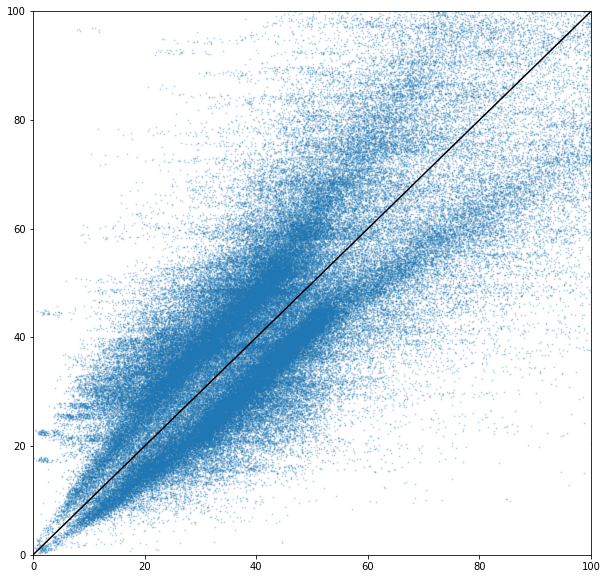

In [34]:
plt.figure(figsize=[10,10])
plt.scatter(Y[:,0]+np.random.rand(len(Y)),Y[:,1]+np.random.rand(len(Y)),1,alpha=0.2)
plt.xlim([0,100])
plt.ylim([0,100])
plt.plot([0,100],[0,100],'k-')

In [35]:
refsensor = np.zeros(len(unq))
refsensor[-1]=1

In [36]:
delta = 24

In [37]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [38]:
def f(x,a,b):
    return x*a+b

This makes it so the smaller id is always first in the pair

In [39]:
def compute_simple_calibration(X,Y,delta,refsensor):
    G = nx.DiGraph()
    maxnum = int(np.max(X[:,1:]))
    #data = np.full([maxnum+1,maxnum+1],np.NaN)
    for it,starttime in enumerate(np.arange(0,np.max(X[:,0]),delta)):
        keep = (X[:,0]>starttime) & (X[:,0]<starttime+delta)
        Xkeep = X[keep,:]
        Ykeep = Y[keep,:]
        for i in range(maxnum+1):
            for j in range(maxnum+1):
                keep = (Xkeep[:,1]==i) & (Xkeep[:,2]==j)
                if len(Ykeep[keep,0])>3: #need a few data points for confidence?
                    logratio=np.nanmean(np.log(Ykeep[keep,0]/Ykeep[keep,1]))
                    popt, pcov = curve_fit(f,Ykeep[keep,1],Ykeep[keep,0])
                    G.add_edge((i,it),(j,it),val=logratio,popt=popt,pcov=pcov,weight=2)
                    popt, pcov = curve_fit(f,Ykeep[keep,0],Ykeep[keep,1])
                    G.add_edge((j,it),(i,it),val=-logratio,popt=popt,pcov=pcov,weight=2)
    maxit = it
    for it,starttime in enumerate(np.arange(0,np.max(X[:,0]),delta)):
        if it>0:
            for i in range(maxnum+1):
                #if np.all(np.isnan(data[i,:])): continue
                if np.any([(i,j) in G.nodes for j in range(maxit)]):
                    popt = np.array([0,0])
                    pcov = np.eye(2)
                    G.add_edge((i,it-1),(i,it),val=0,popt=popt,pcov=pcov,weight=1)
                    G.add_edge((i,it),(i,it-1),val=0,popt=popt,pcov=pcov,weight=1)
                    
    allsp = {}
    for ref in np.where(refsensor)[0]:
        for timeidx in range(maxit+1):

            #sp = nx.shortest_paths.single_target_shortest_path(G,(ref,timeidx))
            sp = nx.shortest_paths.single_source_dijkstra_path(G,(ref,timeidx))
            for s in sp:
                if s in allsp:
                    if len(sp[s])<len(allsp[s]):
                        allsp[s]=sp[s]
                else:
                    allsp[s]=sp[s]
    allcals = {}
    allcallists = {}
    allpopts = {}
    allpcovs = {}
    allpoptslists = {}
    for s in allsp:
        allcallists[s] = [G.get_edge_data(u,v)['val'] for u,v in zip(allsp[s][:-1],allsp[s][1:])]
        allcals[s] = np.sum([G.get_edge_data(u,v)['val'] for u,v in zip(allsp[s][:-1],allsp[s][1:])])
        allpoptslists[s] = [G.get_edge_data(u,v)['popt'] for u,v in zip(allsp[s][:-1],allsp[s][1:])]
        allpopts[s] = np.sum(np.log([G.get_edge_data(u,v)['popt'] for u,v in zip(allsp[s][:-1],allsp[s][1:])]),0)
        allpcovs[s] = np.sum([G.get_edge_data(u,v)['pcov'] for u,v in zip(allsp[s][:-1],allsp[s][1:])],0)

        #allpopt
    return G,allsp,allcals,allcallists,allpopts,allpcovs,allpoptslists




In [40]:
G,allsp,allcals,allcallists,allpopts,allpcovs,allpoptslists = compute_simple_calibration(X,Y,delta,refsensor)
allcals

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log
  del sys.path[0]
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in log
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log


{(34, 0): 0.0,
 (2, 0): -0.034204360809672874,
 (34, 1): 0.0,
 (2, 1): -0.11630147232215529,
 (34, 2): 0.0,
 (2, 2): -0.24837035014619355,
 (34, 3): 0.0,
 (2, 3): -0.3428949723811335,
 (32, 3): 0.14563531029974103,
 (34, 4): 0.0,
 (2, 4): -0.23364883536884132,
 (34, 5): 0.0,
 (5, 3): 0.15938327454873166,
 (8, 3): 0.17985581849530843,
 (11, 3): 0.46117767855605435,
 (32, 2): 0.14563531029974103,
 (32, 4): 0.14563531029974103,
 (2, 5): -0.10021391271672095,
 (34, 6): 0.0,
 (32, 1): 0.14563531029974103,
 (32, 5): 0.14563531029974103,
 (2, 6): -0.08361579219364977,
 (34, 7): 0.0,
 (5, 2): 0.15938327454873166,
 (5, 4): 0.15938327454873166,
 (8, 2): 0.17985581849530843,
 (8, 4): 0.17985581849530843,
 (11, 2): 0.46117767855605435,
 (11, 4): 0.46117767855605435,
 (32, 0): 0.14563531029974103,
 (32, 6): 0.14563531029974103,
 (2, 7): -0.13072630851417652,
 (34, 8): 0.0,
 (5, 1): 0.15938327454873166,
 (5, 5): 0.15938327454873166,
 (8, 1): 0.17985581849530843,
 (8, 5): 0.17985581849530843,
 (11, 1

In [41]:
def plot_simple_calibration_graph(G):
    plt.figure(figsize=[15,15])
    #cols = np.array([1 if (n[0]==maxnum) else 0.5 for n in G.nodes])
    #cols += 0.3*np.array([1 if (n[0]==maxnum-1) else 0 for n in G.nodes])
    nx.draw_networkx(G,pos=nx.spring_layout(G))#,node_color=cols)#draw_networkx_edge_labels(G,pos=nx.spring_layout(G))



In [42]:
testX = X
testY = Y
testtrueY = Y

In [48]:
def compute_simple_predictions(testX,testY,testtrueY,allcals,delta):
    #for it,starttime in enumerate(np.arange(0,np.max(X[:,0]),delta)):
    idx = (testX[:,0]/delta).astype(int)
    preds = np.full_like(testtrueY,np.NaN)
    res = []
    res2 = []
    for i,(timeidx,sensorid0,test0,true) in enumerate(zip(idx,testX[:,1],testY[:,0],testtrueY[:,0])):
#         if test0==true: #no point really in testing on when we know the true value
#             continue
        if np.isnan(true): continue
        #temp.append(sensorid0)
        #print((sensorid0,timeidx))
        scaling = np.exp(allcals[(sensorid0,timeidx)])
        preds[i] = scaling*test0
        #print("\nmeasurement:",test0,"\nsensorid:",sensorid0,"\npath:",allsp[(sensorid0,timeidx)],"\nlist:",allcallists[(sensorid0,timeidx)],"\noverall calibration:",allcals[(sensorid0,timeidx)],"\nscaling:",scaling,"\nprediction:",scaling*test0,"\ntruth:",true)
        res2.append([scaling*test0,true])
        res.append([test0,true])
        #print(test1,allcals[(sensorid1,timeidx)],np.exp(-allcals[(sensorid1,timeidx)])*test1,true)
    return preds,res2,res

In [49]:
preds,res2,res = compute_simple_predictions(testX,testY,testtrueY,allcals,delta)
res

KeyError: (9.0, 58)

In [ ]:
# X = []
# Y = []
# for idx,enc in encounters.iterrows():
#     dt = enc['created_at_2_sensorB']+(enc['created_at_2_sensorB']-enc['created_at_2_sensorA'])/2
#     X.append([dt.timestamp()/3600,newid[enc['channel_id_sensorA']],newid[enc['channel_id_sensorB']]])
#     Y.append([enc['pm2_5_sensorA'],enc['pm2_5_sensorB']])
# X = np.array(X)
# Y = np.array(Y)
# Z = np.linspace(min(X[:,0]),max(X[:,0]),50)[:,None]
# refsensor = np.array([1,0])

# delta = pd.Timedelta(1,'day')

# compute_simple_calibration(X, Y, delta, refsensor)